In [5]:
from functions import *

# Set current path if running on docker
path = '/app/Final/code'
# path='.'

In [6]:
# Load data from csv
train = pd.read_csv(path+'/data/train/train.csv')
test = pd.read_csv(path+'/data/test/test.csv')

In [7]:
train.shape

(14993, 24)

In [8]:
train.columns

Index(['Type', 'Name', 'Age', 'Breed1', 'Breed2', 'Gender', 'Color1', 'Color2',
       'Color3', 'MaturitySize', 'FurLength', 'Vaccinated', 'Dewormed',
       'Sterilized', 'Health', 'Quantity', 'Fee', 'State', 'RescuerID',
       'VideoAmt', 'Description', 'PetID', 'PhotoAmt', 'AdoptionSpeed'],
      dtype='object')

In [9]:
train_len = len(train)
data_df = pd.concat([train, test], sort=False).reset_index(drop=True)

## 1. Preprocessing

In [10]:
train_len = len(train)
data_df = pd.concat([train, test], sort=False).reset_index(drop=True)
data_df['Breed_full'] = data_df['Breed1'].astype(str)+'_'+data_df['Breed2'].astype(str)
data_df['Color_full'] = data_df['Color1'].astype(str)+'_'+data_df['Color2'].astype(str)+'_'+data_df['Color3'].astype(str)

data_df['Breed_full'],_ = pd.factorize(data_df['Breed_full'])
data_df['Color_full'],_ = pd.factorize(data_df['Color_full'])
data_df['State'],_ = pd.factorize(data_df['State'])

data_df['hard_interaction'] = data_df['Type'].astype(str)+data_df['Gender'].astype(str)+ \
                              data_df['Vaccinated'].astype(str)+'_'+ \
                              data_df['Dewormed'].astype(str)+'_'+data_df['Sterilized'].astype(str)
data_df['hard_interaction'],_ = pd.factorize(data_df['hard_interaction'])

data_df['MaturitySize'] = data_df['MaturitySize'].replace(0, np.nan)
data_df['FurLength'] = data_df['FurLength'].replace(0, np.nan)

data_df['Vaccinated'] = data_df['Vaccinated'].replace(3, np.nan)
data_df['Vaccinated'] = data_df['Vaccinated'].replace(2, 0)

data_df['Dewormed'] = data_df['Dewormed'].replace(3, np.nan)
data_df['Dewormed'] = data_df['Dewormed'].replace(2, 0)

data_df['Sterilized'] = data_df['Sterilized'].replace(3, np.nan)
data_df['Sterilized'] = data_df['Sterilized'].replace(2, 0)


data_df['Health'] = data_df['Health'].replace(0, np.nan)
data_df['age_in_year'] = (data_df['Age']//12).astype(np.int8)
data_df['avg_fee'] = data_df['Fee']/data_df['Quantity']
data_df['avg_photo'] = data_df['PhotoAmt']/data_df['Quantity']

# name feature
pattern = re.compile(r"[0-9\.:!]")
data_df['empty_name'] = data_df['Name'].isnull().astype(np.int8)
data_df['Name'] =data_df['Name'].fillna('')
data_df['name_len'] = data_df['Name'].apply(lambda x: len(x))
data_df['strange_name'] = data_df['Name'].apply(lambda x: len(pattern.findall(x))>0).astype(np.int8)

In [11]:
data_df['color_num'] = 1
data_df['color_num'] += data_df['Color2'].apply(lambda x: 1 if x!=0 else 0)
data_df['color_num'] += data_df['Color3'].apply(lambda x: 1 if x!=0 else 0)

In [12]:
# breed feature
labels_breed = pd.read_csv(path+'/data/breed_labels.csv')
labels_breed.rename(index=str, columns={'BreedName':'Breed1Name'},inplace=True)
labels_breed['Breed2Name'] = labels_breed['Breed1Name'].values

In [13]:
data_df = data_df.merge(labels_breed[['BreedID','Breed1Name']], left_on='Breed1', right_on='BreedID', how='left')
data_df.drop('BreedID',axis=1,inplace=True)
data_df = data_df.merge(labels_breed[['BreedID','Breed2Name']], left_on='Breed2', right_on='BreedID', how='left')
data_df.drop('BreedID',axis=1,inplace=True)
data_df['Breed2Name'].fillna('',inplace=True)
data_df['BreedName_full'] = data_df['Breed1Name']+' '+data_df['Breed2Name']

In [14]:
data_df['breed_noname'] = data_df['BreedName_full'].isnull().astype(np.int8)
data_df['BreedName_full'].fillna('',inplace=True)
data_df['BreedName_full'] = data_df['BreedName_full'].str.lower()

In [15]:
data_df['breed_num'] = 1
data_df['breed_num'] += data_df['Breed2'].apply(lambda x: 1 if x!=0 else 0)
data_df['breed_mixed'] = data_df['BreedName_full'].apply(lambda x: x.find('mixed')>=0).astype(np.int8)
data_df['breed_Domestic'] = data_df['BreedName_full'].apply(lambda x: x.find('domestic')>=0).astype(np.int8)
data_df['pure_breed'] = ((data_df['breed_num']==1)&(data_df['breed_mixed']==0)).astype(np.int8)

### Split the data

In [16]:
n_splits = 3
split_index = []

kfold = StratifiedKFold(n_splits=n_splits)
for train_idx, valid_idx in kfold.split(train, train['AdoptionSpeed']):
    split_index.append((train_idx, valid_idx))

## 2. Feature Engineering

In [17]:
feat_df = data_df[['PetID','Color1','Breed1','State','RescuerID','Name','Breed_full','Color_full','hard_interaction']]

### Color feature

In [18]:
agg = {
    'Fee':['mean','std','max'],
    'avg_fee':['mean','std','max'],
    'Breed1':['nunique'],
    #'Gender':['nunique'],
    'Age':['mean','std','max'], 
    'Quantity':['std'],
    'PetID':['nunique']
}
feat = data_df.groupby('Color1').agg(agg)
feat.columns = pd.Index(['COLOR_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='Color1', how='left')

agg = {
    'Fee':['mean','std','max'],
    'avg_fee':['mean','std','max'],
    'Breed_full':['nunique'],
    'Quantity':['sum'],
}
feat = data_df.groupby('Color_full').agg(agg)
feat.columns = pd.Index(['COLORfull_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='Color_full', how='left')

### Breed feature

In [19]:
agg = {
    'Color_full':['nunique'],
    'Breed2':['nunique'],
    'FurLength':['nunique'],
    'Fee':['mean','max'],
    'avg_fee':['mean','std','max'],
    'Age':['mean','std','min','max'],
    'Quantity':['mean','std','max','sum'],
    'PetID':['nunique'],
    'FurLength':['mean'],
    'Health':['mean'],
    'MaturitySize':['mean','std','min','max'],
    'Vaccinated':['mean'],
    'Dewormed':['mean'],
    'Sterilized':['mean']
}
feat = data_df.groupby('Breed1').agg(agg)
feat.columns = pd.Index(['BREED1_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='Breed1', how='left')

# Breed feature
agg = {
    'Color_full':['nunique'],
    'Fee':['mean','min','max'],
    'avg_fee':['mean','std','max'],
    'Quantity':['sum'],
    'PetID':['nunique']
}
feat = data_df.groupby('Breed_full').agg(agg)
feat.columns = pd.Index(['BREEDfull_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='Breed_full', how='left')

### State feature

In [20]:
agg = {
    'Color_full':['nunique'],
    'Breed_full':['nunique'],
    'PetID':['nunique'],
    'RescuerID':['nunique'],
    'Fee':['mean','max'],
    'avg_fee':['mean','std','max'],
    'Age':['mean','std','max'],
    'Quantity':['mean','std','max'],#,'min','sum'
    'FurLength':['mean','std'],
    'Health':['mean'],
    'MaturitySize':['mean','std'],
    'Vaccinated':['mean'],
    'Dewormed':['mean'],
    'Sterilized':['mean'],
    'VideoAmt':['mean','std'],
    'PhotoAmt':['mean','std'],
    'avg_photo':['mean','std']
}
feat = data_df.groupby('State').agg(agg)
feat.columns = pd.Index(['STATE_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='State', how='left')

### Multiple feature

In [21]:
# multiple agg
agg = {
    'Fee':['mean','min','max'],
    'avg_fee':['mean','min','max'],
    'Age':['mean','std','min','max'],
    'Quantity':['mean','std','sum'],
    'PetID':['nunique'],
    'FurLength':['mean'],
    'Health':['mean'],
    'MaturitySize':['mean','std'],
    'Vaccinated':['mean'],
    'Dewormed':['mean'],
    'Sterilized':['mean']
}
feat = data_df.groupby(['State','Breed1','Color1']).agg(agg)
feat.columns = pd.Index(['MULTI_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on=['State','Breed1','Color1'], how='left')

agg = {
    'Fee':['mean','min','max'],
    'avg_fee':['mean','min','max'],
    'Age':['mean','std','min','max'],
    'Quantity':['mean','std','sum'],
    'PetID':['nunique'],
}
feat = data_df.groupby(['State','Breed_full','Color_full']).agg(agg)
feat.columns = pd.Index(['MULTI2_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on=['State','Breed_full','Color_full'], how='left')

### Name feature

In [22]:
# name feature
feat = data_df.groupby('Name')['PetID'].agg(name_count='nunique').reset_index()
feat_df = feat_df.merge(feat, on='Name', how='left')

### Count RescuerID occurrences

In [23]:
agg = {
    'PetID':['nunique'],
    'Breed_full':['nunique'],
    'VideoAmt':['mean','std'],
    'PhotoAmt':['mean','std'],
    'avg_photo':['mean','std'],
    'Sterilized':['mean'],
    'Dewormed':['mean'],
    'Vaccinated':['mean']
}
rescuer_count = data_df.groupby(['RescuerID']).agg(agg)
rescuer_count.columns = pd.Index(['RESCUER_' + e[0] + "_" + e[1].upper() for e in rescuer_count.columns.tolist()])
rescuer_count.reset_index(inplace=True)
feat_df = feat_df.merge(rescuer_count, how='left', on='RescuerID')

### Hard_interaction feature

In [24]:
agg = {
    'Fee':['mean','min','max'],
    'avg_fee':['mean','std','max']
}
feat = data_df.groupby('hard_interaction').agg(agg)
feat.columns = pd.Index(['INTERACTION_' + e[0] + "_" + e[1].upper() for e in feat.columns.tolist()])
feat.reset_index(inplace=True)
feat_df = feat_df.merge(feat, on='hard_interaction', how='left')

### Drop unnecessary columns

In [25]:
feat_df.drop(['Color1','Breed1','State','RescuerID','Name','Breed_full','Color_full','hard_interaction'], axis=1, inplace=True)

In [26]:
feat_df.head()

,PetID,COLOR_Fee_MEAN,COLOR_Fee_STD,COLOR_Fee_MAX,COLOR_avg_fee_MEAN,COLOR_avg_fee_STD,COLOR_avg_fee_MAX,COLOR_Breed1_NUNIQUE,COLOR_Age_MEAN,COLOR_Age_STD,...,RESCUER_avg_photo_STD,RESCUER_Sterilized_MEAN,RESCUER_Dewormed_MEAN,RESCUER_Vaccinated_MEAN,INTERACTION_Fee_MEAN,INTERACTION_Fee_MIN,INTERACTION_Fee_MAX,INTERACTION_avg_fee_MEAN,INTERACTION_avg_fee_STD,INTERACTION_avg_fee_MAX
0,86e1089a3,18.744265,76.670089,3000,16.732534,67.542356,1500.0,146,8.711980,15.703401,...,1.060660,0.000000,0.000000,0.000000,10.438579,0,500,9.860575,37.517683,500.0
1,6296e909a,18.744265,76.670089,3000,16.732534,67.542356,1500.0,146,8.711980,15.703401,...,NaN,NaN,NaN,NaN,7.621302,0,500,7.029586,49.694115,500.0
2,3422e4906,20.402128,77.129227,2000,18.973187,74.027704,2000.0,135,11.804681,19.450346,...,2.179079,0.144796,0.959184,0.952941,38.650330,0,700,37.996073,101.708699,700.0
3,5842f1ff5,18.744265,76.670089,3000,16.732534,67.542356,1500.0,146,8.711980,15.703401,...,4.707039,0.300000,0.877551,0.489796,37.690031,0,1500,36.557373,114.952243,1000.0
4,850a43f90,18.744265,76.670089,3000,16.732534,67.542356,1500.0,146,8.711980,15.703401,...,1.233783,0.046875,0.795455,0.750000,7.871345,0,500,6.997772,35.615495,500.0


### Merge features into train and test

In [27]:
data_df_proc = data_df.copy()
data_df_proc = data_df_proc.merge(feat_df, how='left', on='PetID')

In [28]:
data_df_proc.head()

,Type,Name,Age,Breed1,Breed2,Gender,Color1,Color2,Color3,MaturitySize,...,RESCUER_avg_photo_STD,RESCUER_Sterilized_MEAN,RESCUER_Dewormed_MEAN,RESCUER_Vaccinated_MEAN,INTERACTION_Fee_MEAN,INTERACTION_Fee_MIN,INTERACTION_Fee_MAX,INTERACTION_avg_fee_MEAN,INTERACTION_avg_fee_STD,INTERACTION_avg_fee_MAX
0,2,Nibble,3,299,0,1,1,7,0,1,...,1.060660,0.000000,0.000000,0.000000,10.438579,0,500,9.860575,37.517683,500.0
1,2,No Name Yet,1,265,0,1,1,2,0,2,...,NaN,NaN,NaN,NaN,7.621302,0,500,7.029586,49.694115,500.0
2,1,Brisco,1,307,0,1,2,7,0,2,...,2.179079,0.144796,0.959184,0.952941,38.650330,0,700,37.996073,101.708699,700.0
3,1,Miko,4,307,0,2,1,2,0,2,...,4.707039,0.300000,0.877551,0.489796,37.690031,0,1500,36.557373,114.952243,1000.0
4,1,Hunter,1,307,0,1,1,0,0,2,...,1.233783,0.046875,0.795455,0.750000,7.871345,0,500,6.997772,35.615495,500.0


## 3. Modeling

### 3.0 Prepare data

In [29]:
# Split into train and test again:
X_train = data_df_proc.iloc[0:train_len]
X_test = data_df_proc.iloc[train_len:]

# Remove missing target column from test:
X_test = X_test.drop(['AdoptionSpeed'], axis=1)

print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))

assert X_train.shape[0] == train.shape[0]
assert X_test.shape[0] == test.shape[0]

# Check if columns between the two DFs are the same:
train_cols = X_train.columns.tolist()
train_cols.remove('AdoptionSpeed')

test_cols = X_test.columns.tolist()

assert np.all(train_cols == test_cols)

X_train shape: (14993, 178)
X_test shape: (3972, 177)


In [30]:
to_drop_columns = ['PetID', 'Name', 'RescuerID', 'AdoptionSpeed', 
                    'main_breed_BreedName', 'Description',
                    'BreedName_full','Breed1Name','Breed2Name']

### 3.1 NN Model

### 3.2 Xgboost Model

### 3.2.0 Prepare Features

In [37]:
features = [x for x in X_train.columns if x not in to_drop_columns]
xgb_features = features
len(xgb_features)

170

In [38]:
def pet_xgboost(params, X_train=X_train, xgb_features=xgb_features, split_index=split_index, print_result=True):
    oof_train_xgb = np.zeros((X_train.shape[0]))
    qwks = []

    for n_fold, (train_idx, valid_idx) in enumerate(split_index):  
        X_tr = X_train.iloc[train_idx]
        X_val = X_train.iloc[valid_idx]
        
        y_tr = X_tr['AdoptionSpeed'].values    
        y_val = X_val['AdoptionSpeed'].values
            
        d_train = xgb.DMatrix(X_tr[xgb_features], y_tr)
        d_valid = xgb.DMatrix(X_val[xgb_features], y_val)
        
        since = time.time()
        if print_result:
            print('training XGB:')
        model = xgb.train(params, d_train, num_boost_round = 10000, evals=[(d_valid,'val')],
                        early_stopping_rounds=100, 
                        verbose_eval=500)
        
        val_pred = model.predict(d_valid)
        
        oof_train_xgb[valid_idx] = val_pred
        
        hist = histogram(X_tr['AdoptionSpeed'].astype(int), 
                        int(np.min(X_train['AdoptionSpeed'])), 
                        int(np.max(X_train['AdoptionSpeed'])))
        tr_cdf = get_cdf(hist)
        
        pred_test_y_k = getTestScore2(val_pred, tr_cdf)
        qwk = quadratic_weighted_kappa(X_val['AdoptionSpeed'].values, pred_test_y_k)
        qwks.append(qwk)
        if print_result:
            print("QWK_2 = ", qwk, 'elapsed time:', time.time()-since)
        
    # print('overall rmse: %.5f'%rmse(oof_train_xgb, X_train['AdoptionSpeed']))
    # print('mean QWK =', np.mean(qwks), 'std QWK =', np.std(qwks))
    return np.mean(qwks), np.std(qwks)

### 3.2.1 Grid Search for Xgboost Classifier

In [39]:
from sklearn.model_selection import GridSearchCV

In [40]:
xgb_classifier = xgb.XGBClassifier()
params_search_grid = {
        'eta': [0.01, 0.02, 0.05],
        'max_depth': [5, 6, 7, 8, 9],  
        'subsample': [0.8, 0.9, 1.0],  
        'colsample_bytree': [0.7,0.8, 0.9, 1.0],     
        'alpha': [0.01, 0.02, 0.05, 0.1]
}
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=params_search_grid, cv=5)
# grid_search.fit(X_train[xgb_features], X_train['AdoptionSpeed'])
# grid_search.best_params_

In [41]:
class_params = {'alpha': 0.05,
 'colsample_bytree': 0.8,
 'eta': 0.05,
 'max_depth': 9,
 'subsample': 0.9,
 'objective':'multi:softmax',
 'num_class': 5}
qwk_mean, qwk_std= pet_xgboost(class_params, split_index=split_index)

training XGB:
[0]	val-mlogloss:1.59272
[218]	val-mlogloss:1.28945
QWK_2 =  0.3908426029041525 elapsed time: 7.638688087463379
training XGB:
[0]	val-mlogloss:1.59246
[199]	val-mlogloss:1.30423
QWK_2 =  0.3701213256950946 elapsed time: 7.7654218673706055
training XGB:
[0]	val-mlogloss:1.59272
[202]	val-mlogloss:1.30127
QWK_2 =  0.38185125615451077 elapsed time: 6.6308534145355225


### 3.2.2 Grid Search for Xgboost Regressor

In [42]:
params_search_grid = {
        'objective': ['reg:squarederror'],
        'eval_metric':['rmse'],
        'tree_method':['hist'],
        # 'device':['gpu'],
        'eta': [0.01, 0.02, 0.05],
        'max_depth': [5, 6, 7, 8, 9],  
        'subsample': [0.8, 0.9, 1.0],  
        'colsample_bytree': [0.7,0.8, 0.9, 1.0],     
        'alpha': [0.01, 0.02, 0.05, 0.1]
}
xgb_model = xgb.XGBRegressor()
grid_search = GridSearchCV(estimator=xgb_model, param_grid=params_search_grid, scoring='neg_mean_squared_error', cv=split_index)
# grid_search.fit(X_train[xgb_features], X_train['AdoptionSpeed'])

In [43]:
# grid_search.best_params_
# pet_xgboost(grid_search.best_params_, split_index=split_index)

### 3.2.3 Xgboost Regressor Final Model

In [44]:
params = {
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'tree_method':'hist',
        'eta': 0.01,
        'max_depth': 7,  
        'subsample': 0.8,  
        'colsample_bytree': 0.8,     
        'alpha': 0.05
}
pet_xgboost(params, split_index=split_index, print_result=False)

[0]	val-rmse:1.17535
[500]	val-rmse:1.03021
[1000]	val-rmse:1.02620
[1157]	val-rmse:1.02633
[0]	val-rmse:1.17488
[500]	val-rmse:1.03811
[1000]	val-rmse:1.03298
[1241]	val-rmse:1.03267
[0]	val-rmse:1.17539
[500]	val-rmse:1.03446
[1000]	val-rmse:1.02995
[1105]	val-rmse:1.03029


(0.4629055637471855, 0.006937171365693069)

In [45]:
params_base = {
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'tree_method':'hist',
}
params_search = {
        'eta': 0.01,
        'max_depth': 8,  
        'subsample': 0.8,  
        'colsample_bytree': 0.8,     
        'alpha': 0.05
}

pet_xgboost({**params_base, **params_search}, split_index=split_index)

training XGB:
[0]	val-rmse:1.17524
[500]	val-rmse:1.02785
[961]	val-rmse:1.02540
QWK_2 =  0.4659224432667599 elapsed time: 6.7434351444244385
training XGB:
[0]	val-rmse:1.17477
[500]	val-rmse:1.03504
[1000]	val-rmse:1.03152
[1043]	val-rmse:1.03171
QWK_2 =  0.45603027955444553 elapsed time: 7.772824764251709
training XGB:
[0]	val-rmse:1.17526
[500]	val-rmse:1.03132
[906]	val-rmse:1.02930
QWK_2 =  0.46055492754705674 elapsed time: 6.540719270706177


(0.46083588345608745, 0.004043342503005964)

In [46]:
params_base = {
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'tree_method':'hist',
        # 'device':'cuda:0',
}
params_search = {
        'eta': 0.01,
        'max_depth': 9,  
        'subsample': 0.8,  
        'colsample_bytree': 0.8,     
        'alpha': 0.01
}

pet_xgboost({**params_base, **params_search}, split_index=split_index, print_result=False)

[0]	val-rmse:1.17521
[500]	val-rmse:1.02533
[822]	val-rmse:1.02478
[0]	val-rmse:1.17466
[500]	val-rmse:1.03288
[863]	val-rmse:1.03216
[0]	val-rmse:1.17518
[500]	val-rmse:1.02965
[725]	val-rmse:1.02920


(0.4626166084637367, 0.004751256454979548)

### Importances

In [47]:
from xgboost import XGBRegressor
params = {
        'objective': 'reg:squarederror',
        'eval_metric':'rmse',
        'tree_method':'hist',
        'eta': 0.01,
        'max_depth': 7,  
        'subsample': 0.8,  
        'colsample_bytree': 0.8,     
        'alpha': 0.05
}
train_idx, valid_idx = split_index[0]

X_tr = X_train.iloc[train_idx]
X_val = X_train.iloc[valid_idx]
        
y_tr = X_tr['AdoptionSpeed'].values    
y_val = X_val['AdoptionSpeed'].values
            
d_train = xgb.DMatrix(X_tr[xgb_features], y_tr)
d_valid = xgb.DMatrix(X_val[xgb_features], y_val)
# Get the importance of each feature

model = XGBRegressor(**params)
model.fit(X_tr[xgb_features], y_tr)
# model = xgb.train(params, d_train, num_boost_round = 10000, evals=[(d_valid,'val')], early_stopping_rounds=100, verbose_eval=500)

XGBRegressor(alpha=0.05, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eta=0.01, eval_metric='rmse',
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, ...)

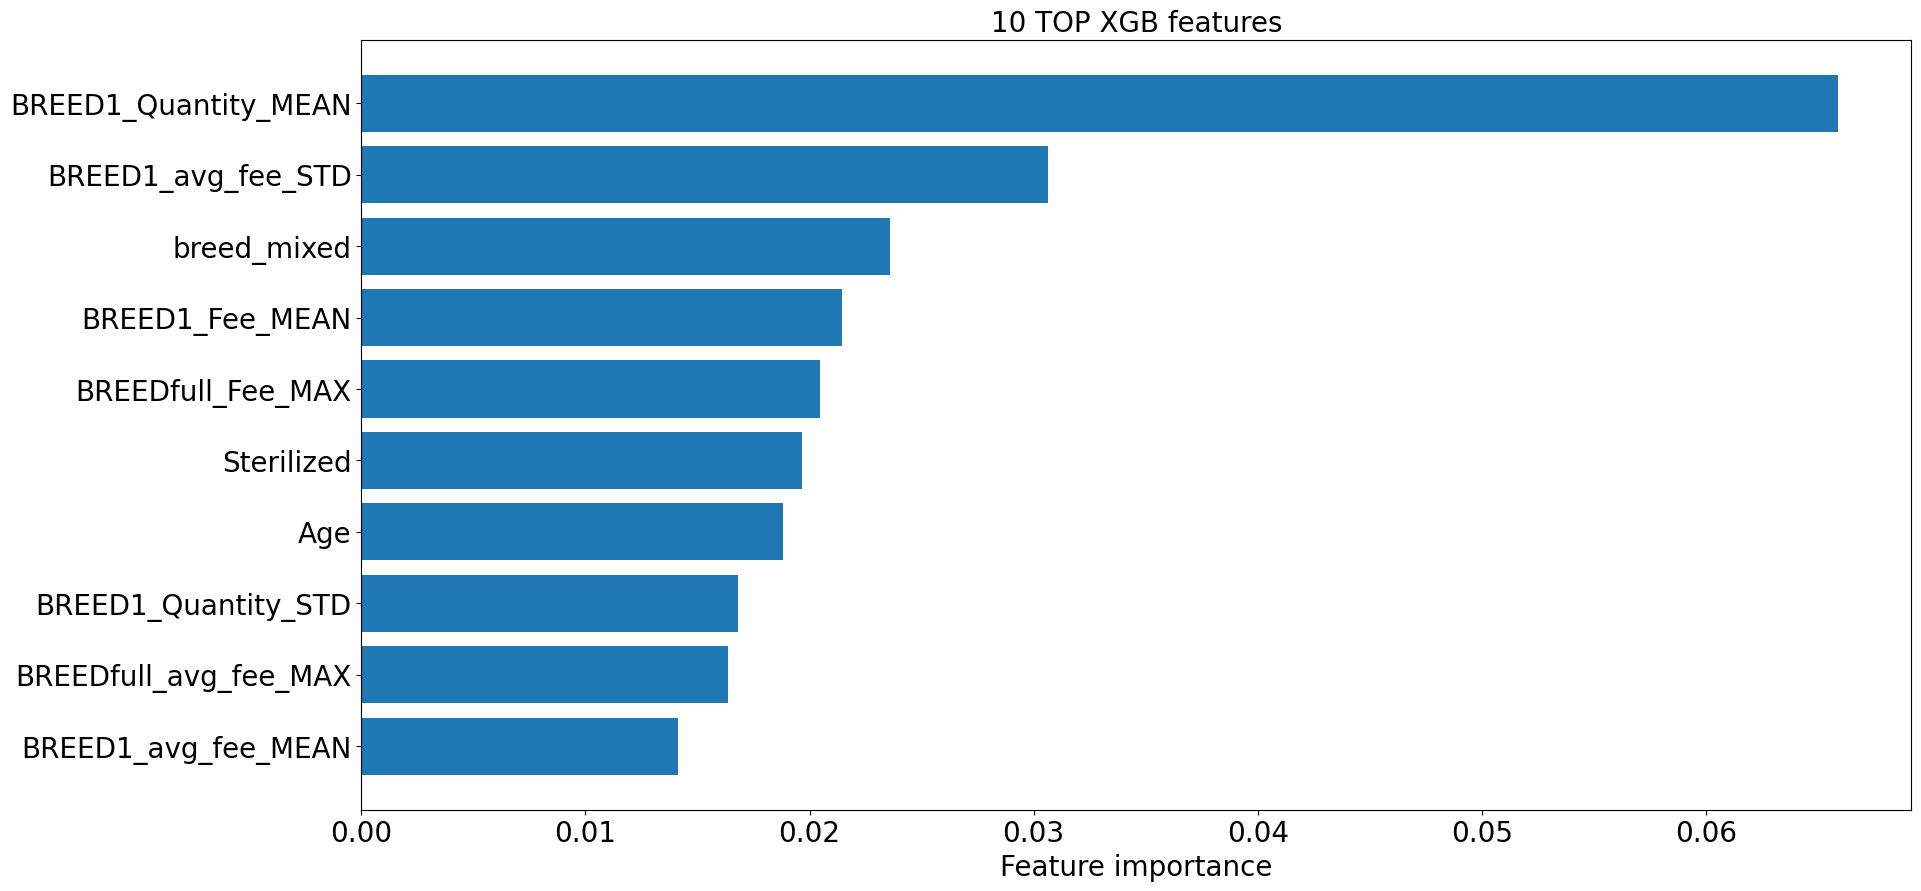

In [48]:
import matplotlib.pyplot as plt
all_feature = pd.DataFrame({'feature':xgb_features, 'importance':model.feature_importances_})
all_feature.sort_values('importance', ascending=True, inplace=True)
to_plot = all_feature[-10:]
plt.figure(figsize=(20,10))
plt.barh(to_plot['feature'], to_plot['importance'])
plt.xlabel('Feature importance', fontsize=20)
# plt.ylabel('Feature', fontsize=20)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.title('10 TOP XGB features', fontsize=20)
plt.savefig('./figure/xgb_feature_importance.png',dpi=300)
# plt.show()
